In [2]:
import itertools
from itertools import combinations
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from matplotlib.lines import Line2D  # Import Line2D for custom legend


import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt
from pymc.distributions.transforms import Ordered


from collections import Counter
import pickle
import random
import itertools
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.1
numpy==1.26.4
seaborn==0.13.2
arviz==0.17.0
pymc==5.10.3


# Introduction

This notebook runs the tests for the focus questions of the study. We preregistered these questions, along with what we expect to find and how we are trying to answer them. We first use simulated data to try out these tests.

These are the questions/hypotheses that we preregistered. For all of these, we will report the distributions rather than the outcome of a binary hypothesis test (as there are no immediate use-cases that allow us to determine a ROPE and appropriate HDI that are required for such a binary test).

1) **How strong is the variation between raters' judgements of societal relevance?**

<u>Expectations:</u> There is substantial variation between raters' judgements of the societal relevance of papers.

<u>Methods:</u>

    1.1) *Use the model to get posterior predictive samples from new raters and paper sets to estimate the effect size of rater characeristics (chauvinism and strictness).* More precisely, we will estimate how much we should expect the proportion of 1s (for strictness and chauvinism) and the mean rank score (for chauvinism) to change when you change from one random rater to another.

    1.2) *Compare the effect size of the rater characeristics (strictness and chauvinism) with that of fields.* More precisely, we look at the differences between the effect sizes of fields (i.e. switching from one field to another), chauvinism (switching from one rater to another) and strictness (switching from one rater to another). If the difference between effect sizes for a pair centers around zero, we have no strong reason to think they are different. If they are clearly positive or negative, one is clearly bigger than the other.


2) **Are there differences between fields?**

<u>Expectations:</u> There are differences between fields. More precisely, we expect fields that clearly higher proportions of the content codes (such as ethics, empirical, health and wellbeing) to score higher than fields that have a lower proportion of papers on these topics.

<u>Methods:</u> 

    2.0) *Compare the expected proportion of 1s of all the fields.* We will draw posterior predictive samples from many trials with randomly drawn raters and papers, and assume they are from each of the five fields in turn. We then compare how the expected proportion of papers deemed societally relevant changes between these. This gives us a direct comparison between each of the fields, as well as a ranking of fields in terms of expected proportions of papers deemed societally relevant.


3) **Are raters chauvinistic?**

<u>Expectations:</u> We expect that raters will value papers from their own field higher, either because they are biased or because they understand these papers better than other raters.

<u>Methods:</u> 

    3.0) *Compare the expected proportion of 1s of trials including chauvinism with trials excluding chauvinism.* We will draw posterior predictive samples from many trials with randomly drawn raters and papers, both with and without chauvinism included in the linear model. We then compare how the expected proportion of papers deemed societally relevant changes between these. This gives us a direct estimate of the difference chauvinism makes, and whether it indeed increases the numbers of papers deemed societally relevant by the raters. Note that this is different from looking at the expected difference between two random raters (in that test used in 1.1 and 1.2 the chauvinism parameter is always included in the model).

4) **What is the aggregate judgement on the societal relevance?**

<u>Expectations:</u> Based on previous studies and our own experiences with our own humanities fields, we expect the aggregate judgement to be below 50%. 

<u>Methods:</u> 

    4.0) *Determine the expected proportion of 1s of trials with chauvinism excluded from the linear model.* We will draw posterior predictive samples from the model without chauvinism. We exclude chauvinism because for this test we are interested in the 'true relevance', i.e. without a biasing factor like chauvinism. We could exclude strictness as well, but this doesn't really make conceptual sense (you can select raters from another field to exclude chauvinism, but any hypothetical rater will still have their own strictness) and it would assume that all raters are well calibrated on a single threshold of funding for the ideal committee. So, we include it but sample from thousands of different raters to make sure that any extremes are washed out.


5) **What is the influence of certain paper topics (content codes)?**

<u>Expectations:</u> We selected the content codes on the basis of what we thought would be relevant, and on the basis of what others have associated with societal relevance. Hence, we expect the effect of these codes to be quite strong. 

    5.0) *Compare the expected proportion of 1s of all the codes.* We will draw posterior predictive samples from many trials with randomly drawn raters, fields and papers, and assume they are from each of the content codes exclusively in turn. We then compare how the expected proportion of papers deemed societally relevant changes between these, and from the same without any content codes. This gives us a direct comparison between each of the content codes, as well as between each of the content codes and the absence of all of the codes.

6) **What is the influence of paper intercepts compared to that of the content codes and fields?**

<u>Expectations:</u> While we expect the content codes to capture a substantial part of the variation, there are innumerably more topics than those that might be societally relevant. In addition, stylistic features might influence the estimated paper value. As a result, we expect that paper intercepts (which capture all paper value apart from content codes and field influence) will vary strongly and have a lot of influence as well.

# Data



In [3]:
cat_cols = ['sex','weird','rater','field','new_rater_disc', 'abstract','doctype']

df = pd.read_csv(r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\combined_data.csv", dtype = {i:'category' for i in cat_cols},  index_col=0)
df_main = pd.read_csv(r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\df_main.csv",dtype = {i:'category' for i in cat_cols}, index_col=0)


content_codes = ['fiction','present', 'intolerance', 'ethics', 'empirical', 'environment','education', 'wellbeing', 'deliverable']

content_params = content_codes +['doctype']
fields_order = ['History','Philosophy','Religion','Linguistics','Literature']
fields_names = ['History', 'Linguistics', 'Literature', 'Philosophy', 'Religion']
rater_fields_names = ['History', 'Linguistics', 'Literature', 'Philosophy', 'Religion', 'non-humanities']

print(f"columns: {df.columns.values}")
print('')
df.head(2)


columns: ['original_index' 'doi' 'title' 'abstract_text' 'pubyear' 'doctype'
 'rater' 'block' 'field' 'ordinal' 'binary' 'group' 'rater_disc'
 'nationality' 'sex' 'weird' 'field_group' 'abstract' 'chauvinism'
 'present' 'intolerance' 'ethics' 'empirical' 'environment' 'fiction'
 'education' 'wellbeing' 'deliverable' 'capture' 'citation' 'socialmedia'
 'mention' 'outlier' 'usage' 'abstract_length' 'abstract_wordcount'
 'humanities' 'new_rater_disc' 'abstract_length_norm']



,original_index,doi,title,abstract_text,pubyear,doctype,rater,block,field,ordinal,...,citation,socialmedia,mention,outlier,usage,abstract_length,abstract_wordcount,humanities,new_rater_disc,abstract_length_norm
0,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,151_main,QID1_1_main,History,2,...,NaN,NaN,NaN,NaN,NaN,937,134,1,History,-0.285797
1,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,111_main,QID1_1_main,History,1,...,NaN,NaN,NaN,NaN,NaN,937,134,1,Philosophy,-0.285797


In [4]:
# Function to check if value is integer and replace if not
def replace_non_integers_in_column(value, replacement):
    if isinstance(value, int):
        return value
    else:
        return replacement
# turn df into usable data and indexing for the model
def prep_data_thurston(df, group):
    
    out = {}
    # get the data from the main study

    dfm = df.loc[df.group == group].sort_values(['block','abstract','rater']).copy()

    J = len(dfm.rater.unique())
    B = len(dfm.block.unique())
    
    # data for the content parameters
    if 'doctype' in dfm.columns:
        dfm['doctype'] = dfm['doctype'].cat.codes
    content_df = dfm.drop_duplicates(subset = 'doi')[content_params+['block','abstract','field']].sort_values(['block','abstract']).copy()
    content_presence = content_df[content_params].values
    
    out['content_presence'] = content_presence
    
    # data for the fields
    fields_order = ['History','Philosophy','Religion','Linguistics','Literature']
    fields_presence = np.tile(np.arange(K), (B, 1))

    out['fields_presence'] = fields_presence
    
    # get chauvinism data
    
    rater_fields = dfm.drop_duplicates(subset='rater')[['rater','rater_disc']].sort_values('rater')
    rater_fields = rater_fields.replace({'History':0, 'Philosophy':1, 'Religion':2,'Linguistics':3, 'Literature':4})
    
    
            
    rater_fields['rater_disc'] = rater_fields['rater_disc'].apply(lambda x: replace_non_integers_in_column(x,5))
    rater_fields_dct = {rater_fields['rater'].values[i] : rater_fields['rater_disc'].values[i] for i in range(len(rater_fields))}
    
    chauv_array = np.zeros((B, J, K), dtype=int)
    for i in range(J):
        if rater_fields['rater_disc'].values[i] < 5:
            chauv_array[:, i, rater_fields['rater_disc'].values[i]] = 1
        else:
            pass

    out['chauv_array'] = chauv_array

    # rater fields
    categories = ['History', 'Philosophy', 'Linguistics', 'Literature', 'Religion','Non-humanities']

    dfm['CategoricalColumn'] = pd.Categorical(dfm['new_rater_disc'], categories=categories)
    dfm['codes'] = dfm['CategoricalColumn'].cat.codes

    discs = dfm[['rater','codes','doi']].drop_duplicates(subset = 'rater')['codes']
    array_2D = np.array([np.full(K, disc) for disc in discs.values])
    rater_fields = np.tile(array_2D, (B, 1, 1))

    out['rater_fields'] = rater_fields
    
    # get the rank data
    
    rank_data = dfm.pivot_table(index=['block', 'rater'], columns='field', values='ordinal', aggfunc='first').reset_index()
    rank_data = rank_data.sort_values(['block','rater'], ascending = True) #
    block_order = rank_data['block'].unique()
    rank_data = rank_data[fields_order].values.reshape(B,J,K)
    rank_data_argsort = np.argsort(rank_data) 

    out['rank_data'] = rank_data.astype('int32')
    out['rank_data_argsort'] = rank_data_argsort.astype('int32')
    
    # get the binary data
    
    binary_data = dfm.pivot_table(index=['block', 'rater'], columns='field', values='binary', aggfunc='first').reset_index()
    binary_data = binary_data.sort_values(['block','rater'], ascending = True) #
    binary_data = binary_data[fields_order].values.reshape(B,J,K)

    out['binary_data'] = binary_data

    return out

# Set up posterior predictive samples to calculate effect sizes

These posterior predictive samples are used in all the tests, so we calculate them first.

In [62]:
# a few variables shared between the different hypothesis tests

K = 5
colors = ["skyblue","lightgreen","orange","purple","darkred"]
new_J = 10
n_trials = 100
n_sets = 50
n_papers = n_sets * 5

# Paper value effect size

In [6]:
trace_chauv_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all.nc")


In [63]:
trials_papervals = []

n_sets2 = n_sets * int(n_trials / 50)
n_papers2 = n_sets2 * 5

paper_intercepts = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['paper_intercepts'][:,:,-345:].values), n_papers2)

fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['fields'].values), n_papers2)

paper_values = paper_intercepts + fields

strictness_sd = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['strictness_sd'].values), (n_sets2*K*new_J), replace=True)
strictness = np.random.normal(0,strictness_sd).reshape((n_sets2,new_J, K))


    
sigma = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['sigma'].values), (n_sets2 * new_J * K), replace = True)


    # for each trial, sample from the posterior distributions of the parameters

chauvinism = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values), new_J, replace = True ),
                             np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), new_J, replace = True ))

chauvinism2 = np.repeat(chauvinism[:, np.newaxis], K, axis=1)
chauvinism3 = np.repeat(chauvinism2[np.newaxis, :, :], n_sets2, axis=0)
    

    

# make chauvinism array with probabilities of being chauvinistic
probabilities = [0.2,0.2,0.2,0.2,0.2]
new_chauv = np.zeros((n_sets2, new_J, K), dtype=int)

# Populate the array based on probabilities
for b in range(n_sets2):
    for j in range(new_J):
        # Generate random numbers and compare to probabilities
        random_numbers = np.random.rand(K)
        new_chauv[b, j] = (random_numbers < probabilities).astype(int)

rater_fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['rater_field'].values), n_sets2 * K*new_J).reshape(n_sets2, new_J, K)

for i in tqdm(paper_values):




    latent = np.random.normal(np.repeat(i, K*new_J*n_sets2).reshape((n_sets2, new_J, K)) + rater_fields + chauvinism3*new_chauv , sigma.reshape((n_sets2,new_J, K)))

    
    p = expit(latent + strictness)
    
    trials_papervals.append(np.random.binomial(1,p))


100%|██████████| 500/500 [00:00<00:00, 3080.61it/s]


In [8]:
# get paper value es
# we just ran the experiment many times, each time with only one paper value (used many times) per experiment

mean_papervals = [i.mean() for i in trials_papervals]
es_papervals = []
# difference in average score

    
for j in combinations(mean_papervals,2):
    es_papervals.append(abs(j[0] - j[1]))

# Content effect size

In [26]:
trace_content_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_content_thurstonian_all.nc")

In [10]:
# adapt content params when we have all data
content_params2 = content_params[2:]
content_trials = {i:[] for i in content_params}
content_trials['No code'] = []

for trial in tqdm(range(n_trials)):

    strictness_sd = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['strictness_sd'].values), (n_sets*K*new_J), replace=True)
    strictness = np.random.normal(0,strictness_sd).reshape((n_sets,new_J, K))
    
    paper_intercepts = (np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['paper_intercepts'].values),n_papers, replace = True)).reshape(n_sets, K)
    fields = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)

    

    
    sigma = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['sigma'].values), (new_J), replace = True)


    

    for i in range(len(content_params2)):
        content = np.random.choice(np.ravel(trace_content_thurstonian_all.posterior['content'][:,:,i].values),  (n_sets * K)).reshape(n_sets, K)

        paper_values = paper_intercepts + fields + content
    
        latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma.reshape((1,new_J, 1)))
        p = expit(latent + strictness)
        outcome = np.random.binomial(1,p)
        content_trials[content_params2[i]].append(outcome)

    # now also add one that has zero for all content codes, and that is a journal paper
    
    paper_values = paper_intercepts + fields 
    latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma.reshape((1,new_J, 1)))
    p = expit(latent + strictness)
    outcome = np.random.binomial(1,p)
    content_trials['No code'].append(outcome)

100%|██████████| 5000/5000 [02:12<00:00, 37.70it/s]


# Field effect size

Draw posterior predictive sample from the field model to estimate the effect size of field.

In [22]:
# data

trace_field_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_field_thurstonian_all.nc")
# don't include presence in this one

In [12]:

est_papervals_fields = []
trials = []
for trial in tqdm(range(n_trials)):

    strictness_sd = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['strictness_sd'].values), (n_sets*K*new_J), replace=True)
    strictness = np.random.normal(0,strictness_sd).reshape((n_sets,new_J, K))
    paper_intercepts = (np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['paper_intercepts'].values),n_papers, replace = True)).reshape((n_sets, K))
    
    sigma = np.random.choice(np.ravel(trace_field_thurstonian_all.posterior['sigma'].values), (new_J), replace = True)

    field_indices = np.random.choice(az.extract_dataset(trace_field_thurstonian_all.posterior['fields'])['fields'].shape[1], size=n_sets, replace=True)
    fields = (az.extract_dataset(trace_field_thurstonian_all.posterior['fields'])['fields'][:,field_indices]).T.values

    paper_values = paper_intercepts + fields
    latent = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)), sigma.reshape((1,new_J, 1)))
    p = expit(latent + strictness)
    outcome = np.random.binomial(1,p)
    trials.append(outcome)
    est_papervals_fields.append(paper_values)


100%|██████████| 5000/5000 [00:40<00:00, 122.59it/s]


In [13]:
# get field es

es_fields = []
# difference in average score
for i in trials:
    means = i.mean(axis = (0,1))
    for j in combinations(range(K),2):
        es_fields.append(abs(means[j[0]] - means[j[1]]))

# Chauvinism effect size



In [10]:
trace_chauv_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\\trace_chauvinism_thurstonian_all.nc")

mData = prep_data_thurston(df, 'main')
g1Data = prep_data_thurston(df, 'group1')
g2Data = prep_data_thurston(df, 'group2')

J_hum = 11
J_non_hum = 11

mJ = len(df.loc[df.group == 'main']['rater'].unique())
g1J = len(df.loc[df.group == 'group1']['rater'].unique())
g2J = len(df.loc[df.group == 'group2']['rater'].unique())

mB = len(df.loc[df.group == 'main']['block'].unique())
g1B = len(df.loc[df.group == 'group1']['block'].unique())
g2B = len(df.loc[df.group == 'group1']['block'].unique())

There are multiple ways of doing this:

- check the difference in 1s and 0s for chauvinism on and off.
    - Downside: this may hide how some raters are very chauvinism and some are not if they cancel each other out.
    - Upside: this gives an idea of the overall direction chauvinism pushes in, and how strong this push is.
- Check the differences in 1s and 0s if we switch from one rater to another.
    - Downside: If both raters are equally chauvinistic, the effect size is 0 even though the chauvinism has an effect
    - Upside: It shows the importance of luck in the draw of reviewers
 
We check both, and use them to answer different questions


In [89]:
ranking_chauv = []
ranking_nochauv = []
trials_chauv = []
trials_nochauv = []
est_papervals_chauv = []
ranking_chauv2 = []


for trial in tqdm(range(n_trials)):

    strictness_sd = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['strictness_sd'].values), (n_sets*K*new_J), replace=True)
    strictness = np.random.normal(0,strictness_sd).reshape((n_sets,new_J, K))

    # If you want to sample strictness only from g2, uncomment the line below
    # strictness = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['g2strictness'].values), (n_sets*K*new_J), replace=True).reshape((n_sets,new_J, K))

    paper_intercepts = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['paper_intercepts'].values), n_papers).reshape(n_sets, K)
    
    fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)
    
    sigma = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['sigma'].values), (n_sets * new_J * K), replace = True)


    # for each trial, sample from the posterior distributions of the parameters

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), new_J, replace = True ))

    chauvinism2 = np.repeat(chauvinism[:, np.newaxis], K, axis=1)
    chauvinism3 = np.repeat(chauvinism2[np.newaxis, :, :], n_sets, axis=0)
    

    

    # make chauvinism array with decreasing probability of being chauvinistic
    probabilities = [1,0.5,0.25,0.12,0.06]
    new_chauv = np.zeros((n_sets, new_J, K), dtype=int)
    
    # Populate the array based on probabilities
    for b in range(n_sets):
        for j in range(new_J):
            # Generate random numbers and compare to probabilities
            random_numbers = np.random.rand(K)
            new_chauv[b, j] = (random_numbers < probabilities).astype(int)
    
    rater_fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['rater_field'].values), n_sets * K*new_J).reshape(n_sets, new_J, K)
    
    paper_values = paper_intercepts + fields
    est_papervals_chauv.append(paper_values)

    latent_chauv = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields + chauvinism3 , sigma.reshape((n_sets,new_J, K)))
    latent_no_chauv = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields, sigma.reshape((n_sets,new_J, K)))
    
    p_chauv = expit(latent_chauv + strictness)
    p_no_chauv = expit(latent_no_chauv + strictness)
    trials_chauv.append(np.random.binomial(1,p_chauv))
    trials_nochauv.append(np.random.binomial(1,p_no_chauv))

    # now simulate some ranking data

    
    latent_chauv = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields + (chauvinism3 * new_chauv) , sigma.reshape((n_sets,new_J, K)))

    latent_chauv2 = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields + (chauvinism3 ) , sigma.reshape((n_sets,new_J, K)))
    ranking_chauv.append(np.argsort(latent_chauv))
    ranking_nochauv.append(np.argsort(latent_no_chauv))

    ranking_chauv2.append(np.argsort(latent_chauv2))


100%|██████████| 5000/5000 [00:26<00:00, 186.75it/s]


In [90]:
# get chauvinism effect size

# binary first

es_chauv = []
# difference in average score
for i in trials_chauv:
    means = i.mean(axis = (0,2))
    for j in combinations(range(new_J),2):
        es_chauv.append(abs(means[j[0]] - means[j[1]]))


# then rank, switching from chauvinism off to on
es_chauv_rank = []
# difference in average score
for i in range(len(ranking_chauv)):
    mean1 = ranking_chauv[i].mean(axis = (0,1))
    mean2 = ranking_nochauv[i].mean(axis = (0,1))
    for j in range(K):
        es_chauv_rank.append(abs(mean1[j] - mean2[j]))

# then rank, switching between raters
es_chauv_rank2 = []
# difference in average score
for i in range(len(ranking_chauv)):
    means = ranking_chauv[i][:,:,0].mean(axis = 0)
    for j in combinations(range(new_J),2):
        es_chauv_rank2.append(abs(means[j[0]] - means[j[1]]))

# Strictness effect size

Given that it doesn't make conceptual sense to switch strictness on and off -- after all, all raters need to have some strictness level that is going to be individual given the difficulties of imagining the ideal committee -- we mostly focus on the effect of switching from one rater to another and are only planning to report that effect. 

We can use any of the models, as the strictness estimates should be the same, and strictness isn't connected to any of the other variables in the DAG.

In [17]:
trials_strict = []

for trial in tqdm(range(n_trials)):

    # still have to replace this by strictness sd data from the correct trace
    strictness_sd = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['strictness_sd'].values), (new_J), replace=True)
    strictness = np.random.normal(0,strictness_sd).reshape(1,new_J,1)

    
    paper_intercepts = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['paper_intercepts'].values), n_papers).reshape(n_sets, K)
    
    fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['fields'].values), n_papers).reshape(n_sets, K)
    
    sigma = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['sigma'].values), (n_sets * new_J * K), replace = True)


    # for each trial, sample from the posterior distributions of the parameters

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['chauv_sd'].values), new_J, replace = True ))

    chauvinism2 = np.repeat(chauvinism[:, np.newaxis], K, axis=1)
    chauvinism3 = np.repeat(chauvinism2[np.newaxis, :, :], n_sets, axis=0)
    

    

    # make chauvinism array with decreasing probability of being chauvinistic
    new_chauv = np.random.binomial(1, p=0.2, size=(n_sets, new_J, K))

    
    rater_fields = np.random.choice(np.ravel(trace_chauv_thurstonian_all.posterior['rater_field'].values), n_sets * K*new_J).reshape(n_sets, new_J, K)
    
    paper_values = paper_intercepts + fields

    latent_chauv = np.random.normal(np.tile(paper_values[:,np.newaxis,:],(1,new_J,1)) + rater_fields + chauvinism3*new_chauv , sigma.reshape((n_sets,new_J, K)))

    
    p_chauv = expit(latent_chauv + strictness)
    trials_strict.append(np.random.binomial(1,p_chauv))



100%|██████████| 5000/5000 [00:04<00:00, 1096.27it/s]


In [18]:
# get the strictness effect size

es_strictness = []
# difference in average score
for i in trials_strict:
    means = i.mean(axis = (0,2))
    for j in combinations(range(new_J),2):
        es_strictness.append(abs(means[j[0]] - means[j[1]]))

# QUESTION 1: Variation in raters' judgement of societal relevance

## Method 1.1: Absolute effect sizes

All three of these effect sizes will be reported.

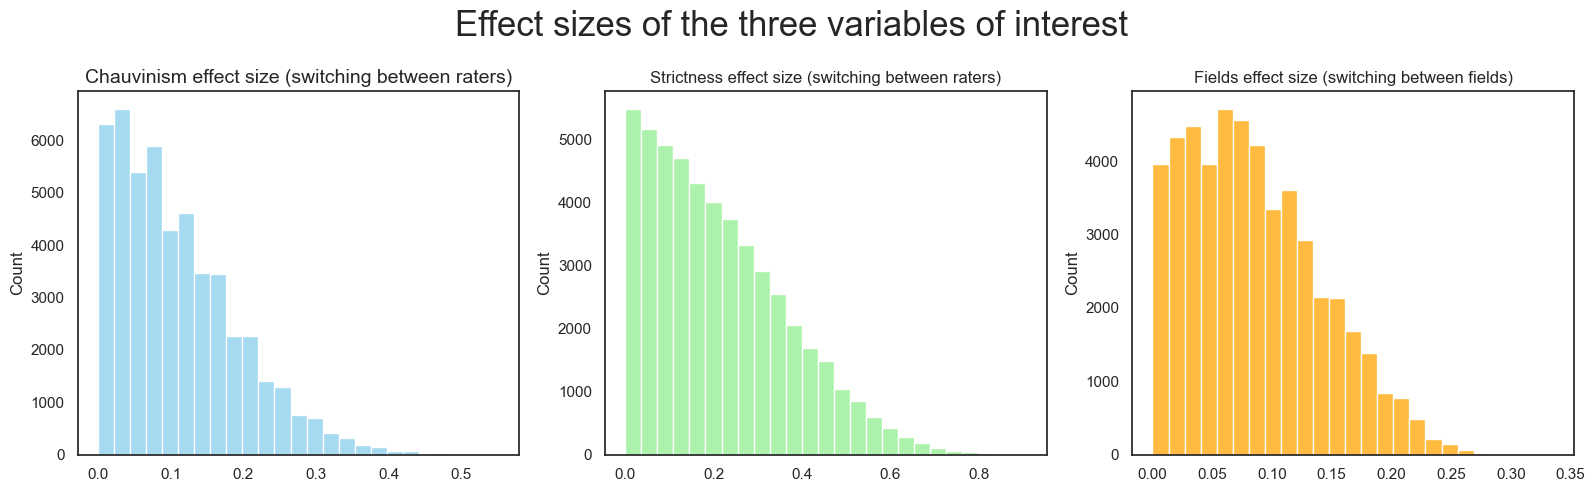

In [70]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5), sharey = False, sharex = False)

n_bins = int(n_trials/15)
ks = 50000
sns.histplot(random.choices(es_chauv, k = ks),bins = 25,ax = ax[0], color = colors[0])
sns.histplot(random.choices(es_strictness, k = ks),bins = 25, ax = ax[1],color = colors[1]) 
sns.histplot(es_fields,bins = 25,ax = ax[2],color = colors[2]) 


ax[0].set_title(f'Chauvinism effect size (switching between raters)', fontsize = 14)
ax[1].set_title(f'Strictness effect size (switching between raters)')
ax[2].set_title(f'Fields effect size (switching between fields)')

plt.suptitle('Effect sizes of the three variables of interest', fontsize = 25)

fig.tight_layout()

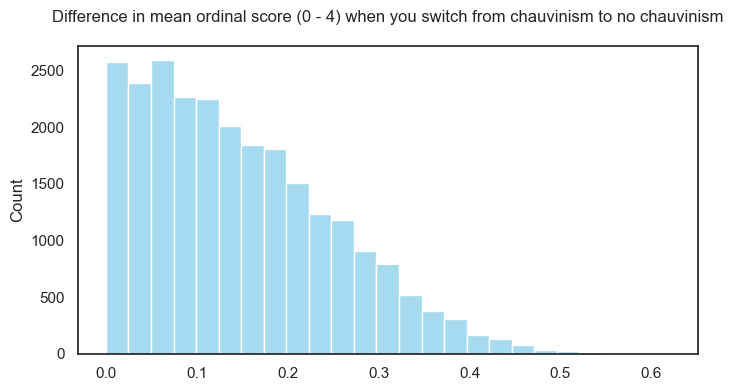

In [71]:
fig, ax = plt.subplots(figsize = (8,4))
sns.histplot(es_chauv_rank,bins = 25,color = colors[0],ax=ax)
ax.set_title('Difference in mean ordinal score (0 - 4) when you switch from chauvinism to no chauvinism', y = 1.05)
plt.show()

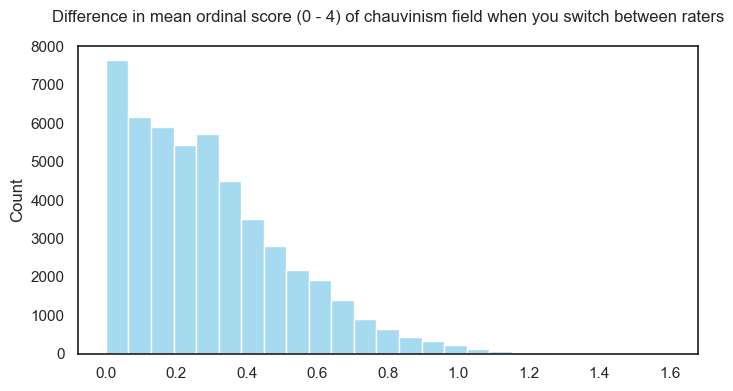

In [72]:
# for chauvinism, we can also plot the effect on rank scores of the field one is chauvinistic about

fig, ax = plt.subplots(figsize = (8,4))
sns.histplot(random.choices(es_chauv_rank2, k = ks),bins =25,color = colors[0],ax=ax)
ax.set_title('Difference in mean ordinal score (0 - 4) of chauvinism field when you switch between raters', y = 1.05)
plt.show()

## Method 1.2: Compare the effect sizes of chauvinism, strictness and field

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001A58EC0A660>
Traceback (most recent call last):
  File "C:\Users\conix\.conda\envs\pymc_env\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


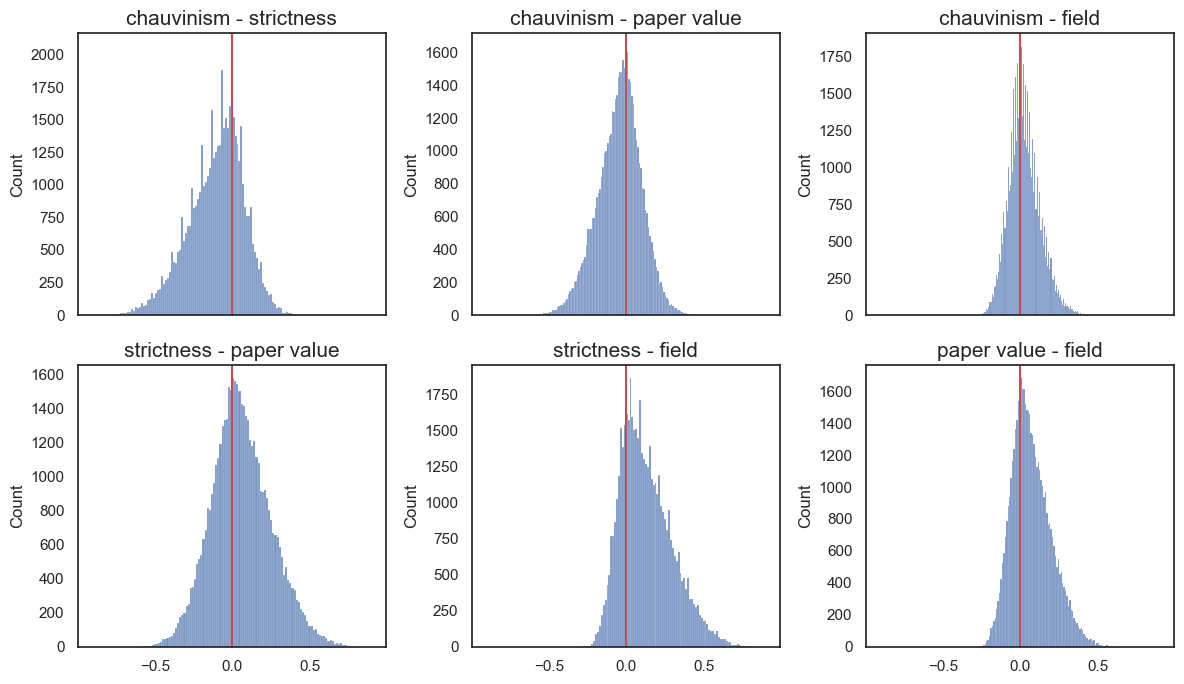

In [73]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12,7), sharey = False, sharex = True)

es_strictness_short = np.array(random.choices(es_strictness, k=ks))
es_chauv_short = np.array(random.choices(es_chauv, k=ks))
es_papervals_short = np.array(random.choices(es_papervals, k=ks))

dct = {'chauvinism':es_chauv_short,'strictness':es_strictness_short,'paper value':es_papervals_short,'field':es_fields}

for ax, i in zip(axs.flat, combinations(range(4),2)):
    
    sns.histplot(list(dct.values())[i[0]]- list(dct.values())[i[1]],ax = ax) #, bw_adjust = 2



    ax.set_title(f'{list(dct.keys())[i[0]]} - {list(dct.keys())[i[1]]}', fontsize = 15)
    ax.axvline(0, color = 'r')

fig.tight_layout()

## Turin conference figure

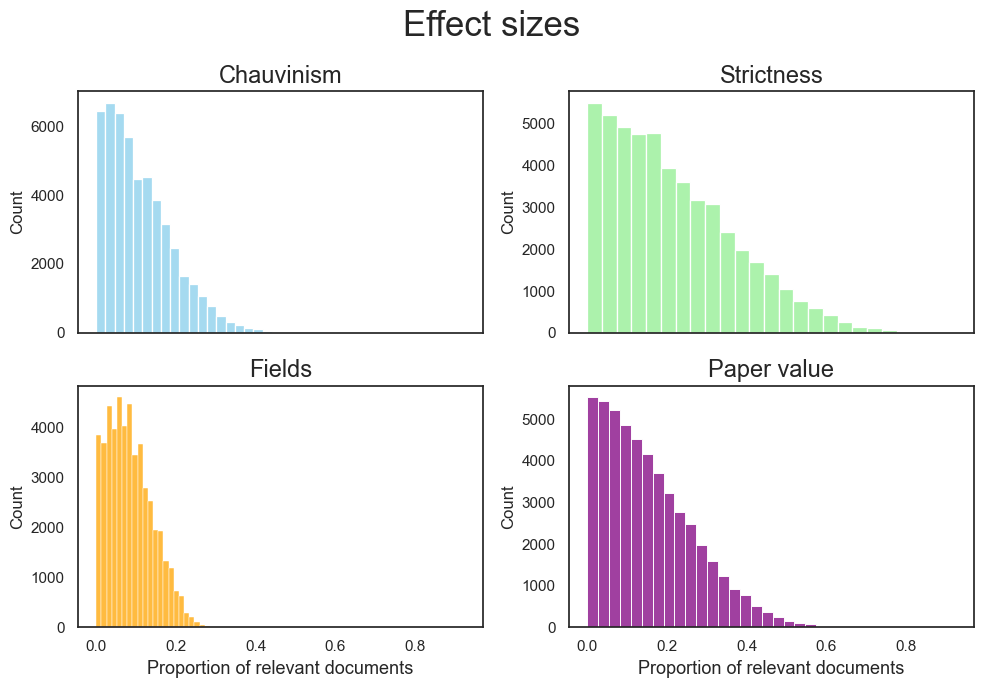

In [74]:
# Figure for conference paper in Turin

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7), sharey = False, sharex = True)

n_bins = int(n_trials/15)

sns.histplot(random.choices(es_chauv, k=ks),bins = 25,ax = ax[0,0], color = colors[0])
sns.histplot(random.choices(es_strictness, k=ks),bins = 25, ax = ax[0,1],color = colors[1]) 
sns.histplot(random.choices(es_fields, k=ks),bins = 25,ax = ax[1,0],color = colors[2]) 
sns.histplot(random.choices(es_papervals, k=ks), bins = 25, color = colors[3], ax=ax[1,1])


ax[0,0].set_title(f'Chauvinism', fontsize = 17)
ax[0,1].set_title(f'Strictness', fontsize = 17)
ax[1,0].set_title(f'Fields', fontsize = 17)
ax[1,1].set_title(f'Paper value', fontsize = 17)

ax[1,0].set_xlabel('Proportion of relevant documents', fontsize = 13)
ax[1,1].set_xlabel('Proportion of relevant documents', fontsize = 13)


plt.suptitle('Effect sizes', fontsize = 25)




fig.tight_layout()
# Save the figure
fig.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\turin_effectsizes.png')

# QUESTION 2: Differences between fields

We will at least report the top figure or ridgeplot, i.e. the one based on posterior predictive samples.

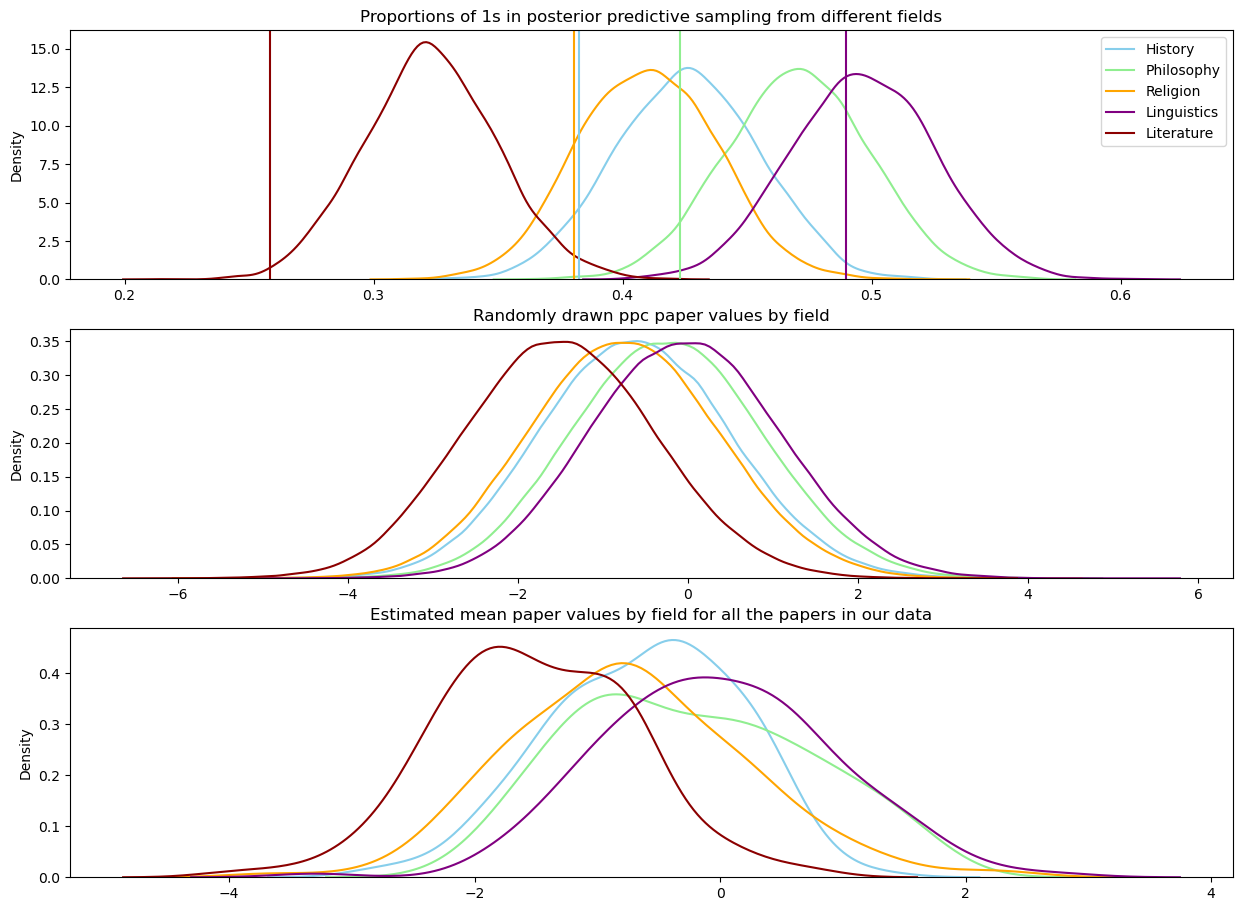

In [56]:
# plot the distribution of proportions of 1s for all fields

fig, ax = plt.subplots(nrows = 3, figsize = (15,11))


for i,field in enumerate(fields_order): 
    trial_means = np.array([trials[i].mean(axis = (0,1)) for i in range(n_trials)])
    f = sns.kdeplot(trial_means[:,i], color = colors[i], ax=ax[0])
    
    paper_vals = np.concatenate([est_papervals_fields[i] for i in range(n_trials)])
    f2 = sns.kdeplot(paper_vals[:,i], color = colors[i], ax=ax[1])
ax[0].legend(fields_order)

# indicate the observed mean of 1s
for i,field in enumerate(fields_order): 
    ax[0].axvline(df.loc[df.field == field]['binary'].mean(), color = colors[i])
    
paper_vals = np.concatenate([trace_field_thurstonian_all.posterior[i].values.mean(axis = (0,1)) for i in ['g1paper_values','g2paper_values','mpaper_values']])

for i in range(5):
    sns.kdeplot(paper_vals[:,i],color = colors[i], ax = ax[2])



ax[0].set_title('Proportions of 1s in posterior predictive sampling from different fields')
ax[1].set_title('Randomly drawn ppc paper values by field')
ax[2].set_title('Estimated mean paper values by field for all the papers in our data')
plt.show()

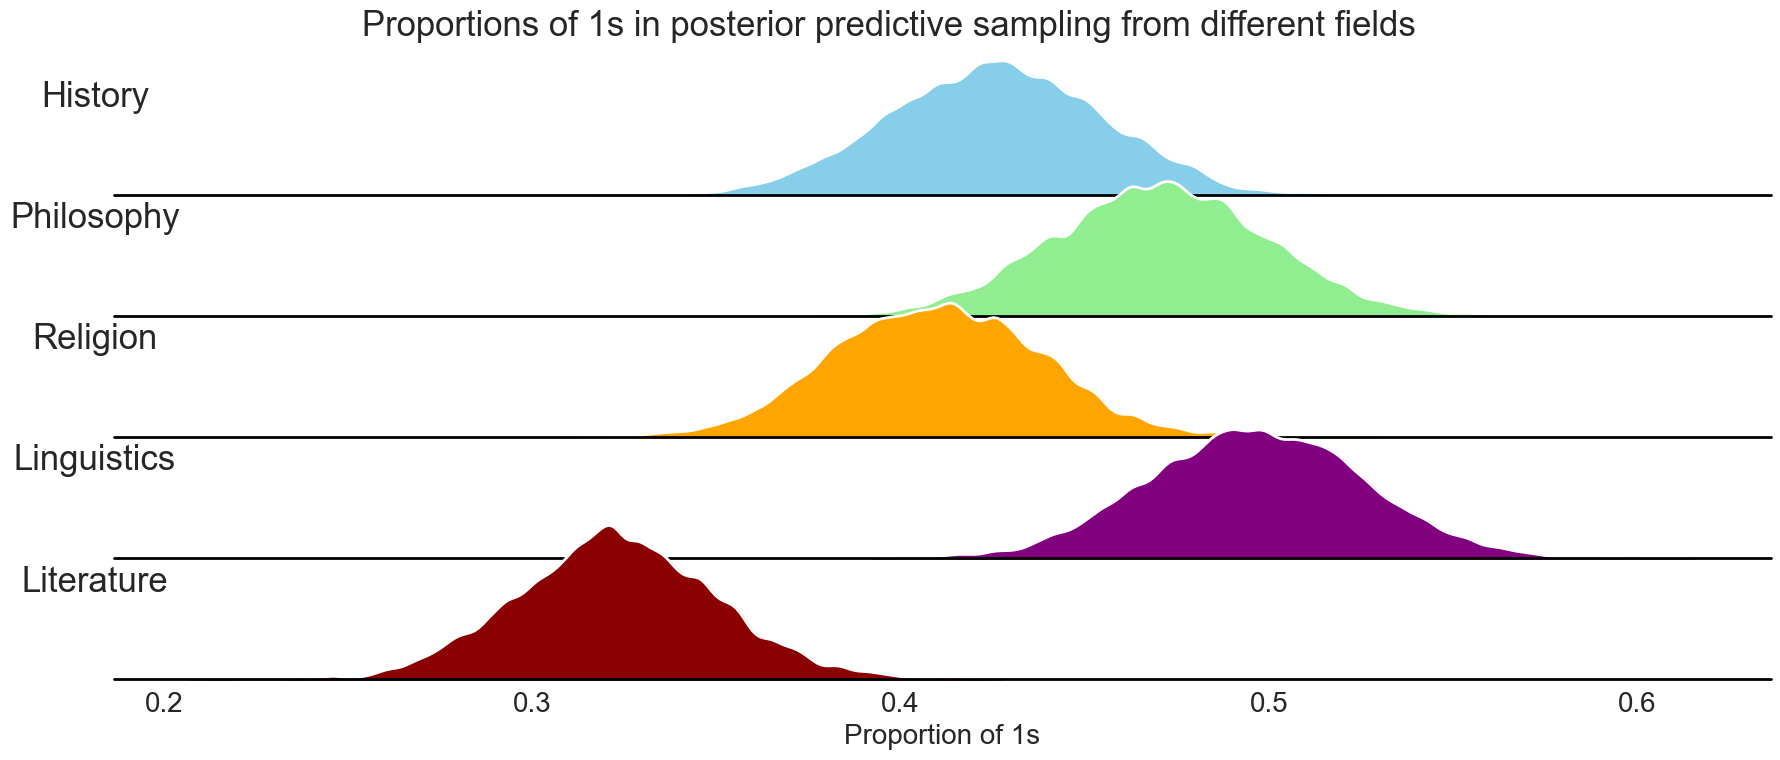

In [57]:
# plot the main figure also as a ridgeplot given that everything is overlapping here

from matplotlib.ticker import FixedLocator

# Ignore the specific UserWarnings related to tight_layout
warnings.filterwarnings('ignore', category=UserWarning)
# Convert dictionary to a long-form DataFrame for seaborn
dfx = pd.DataFrame(trial_means)
dfx = dfx.melt(var_name='Field', value_name='Effect Size')

# Create the ridge plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data for the ridge plot
g = sns.FacetGrid(dfx, row="Field", hue="Field", aspect=12, height=1.5, palette=colors)

# Map the density plots to each facet
g.map(sns.kdeplot, "Effect Size", clip_on=False, shade=True, alpha=1, lw=1.5, bw_adjust=0.5)
g.map(sns.kdeplot, "Effect Size", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Define a function to add a line for each level
def add_line(x, **kwargs):
    plt.axhline(y=x.name, color='black', lw=2, clip_on=False)

# Apply the function to each facet
g.map(add_line, "Effect Size")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_xlabels("Proportion of 1s", fontsize = 20)
g.set_ylabels('')
ytick_positions = [0, 1, 2,3,4]
for ax, field in zip(g.axes.flat,fields_order):
    ax.set_yticks([4])  # Each subplot has a single y-tick at position 0
    ax.set_ylabel(field, fontsize = 25, rotation = 0)
    ax.tick_params(axis='x', labelsize=20)

g.despine(bottom=True, left=True)
plt.suptitle("Proportions of 1s in posterior predictive sampling from different fields", fontsize = 25)

# Show the plot
plt.show()


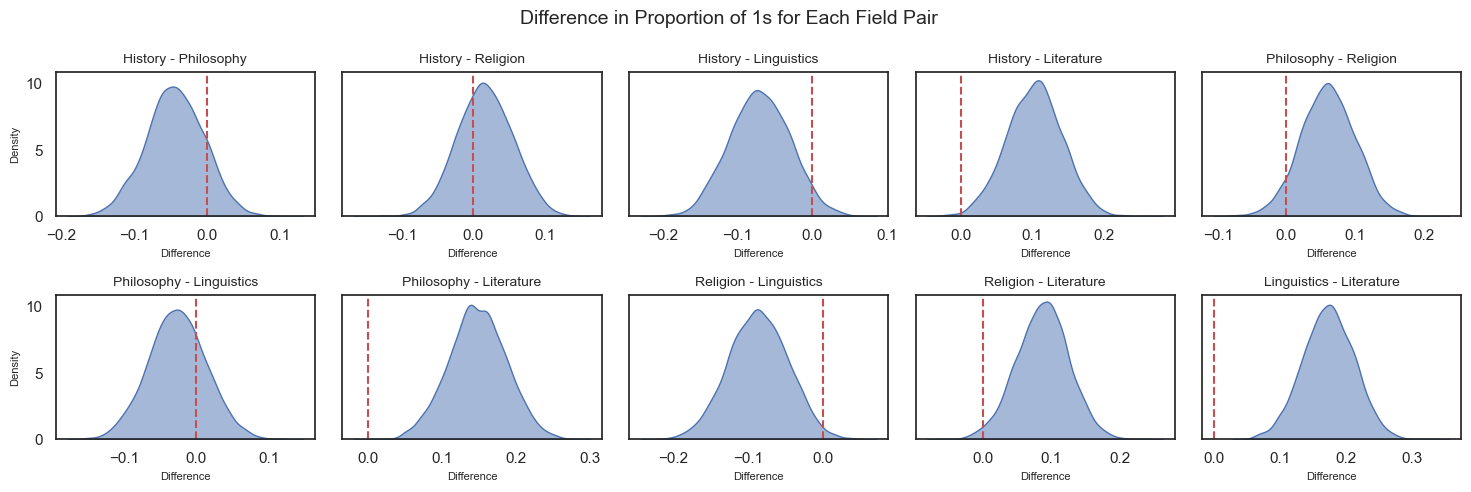

In [58]:
# plot the individual comparisons between fields
field_effect_sizes = {}
fig, axs = plt.subplots(2,5,figsize = (15,5), sharey=True)

for ax,i in zip(axs.flat, combinations(range(5),2)):
    
    # get the proportions of 1s in each of the ppc samples for each pair of fields
    field_a = trial_means[:,i[0]]
    field_b = trial_means[:,i[1]]
    
    # subtract the smaller from the larger
    
    
    dif = field_a - field_b

        
    # store and plot
    
    field_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax, fill=True, alpha=0.5)

    ax.set_title(f'{fields_order[i[0]]} - {fields_order[i[1]]}', fontsize=10)
    ax.axvline(0, color='r', linestyle='--')  # Use a dashed line for visual clarity
    ax.set_xlabel('Difference', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)

plt.suptitle('Difference in Proportion of 1s for Each Field Pair', fontsize=14)
fig.tight_layout()
plt.show()

# QUESTION 3: Are raters chauvinistic?

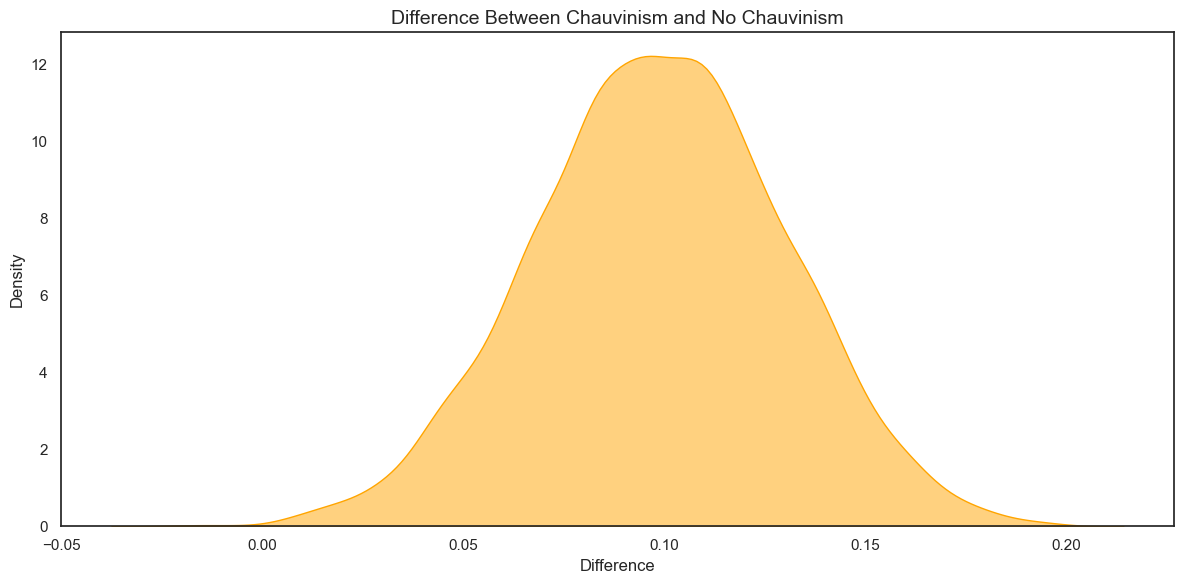

In [59]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(style="white")

text = ['Chauvinism', 'No Chauvinism']
chauv_mean = [trials_chauv[i].mean() for i in range(len(trials_chauv))]
nochauv_mean = [trials_nochauv[i].mean() for i in range(len(trials_nochauv))]


difference = np.array(chauv_mean) - np.array(nochauv_mean)
f2 = sns.kdeplot(difference, ax=ax, color='orange', fill=True, alpha=0.5)
ax.set_title('Difference Between Chauvinism and No Chauvinism', fontsize=14)
ax.set_xlabel('Difference', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

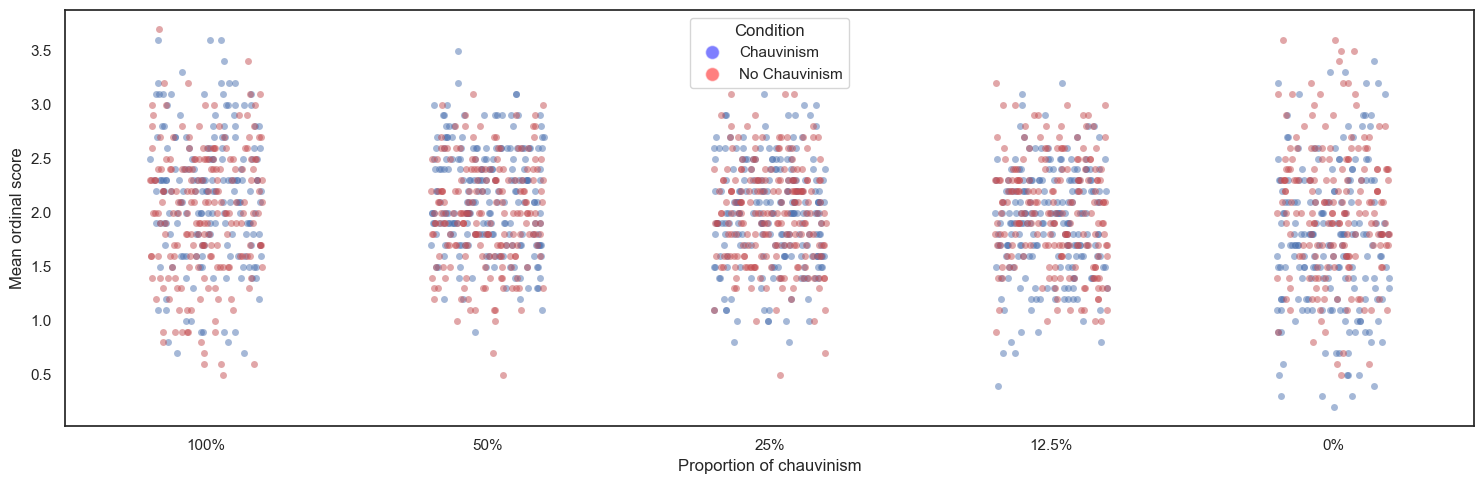

In [60]:
# plot the effect on ranking of switching on and off chauvinism

# Calculate counts of each score
scores = np.arange(5)  # Scores from 0 to 4

chauv_counts = np.concatenate([ranking_chauv[i] for i in range(len(ranking_chauv))])
chauv_counts = chauv_counts.mean(axis = (1))

nochauv_counts = np.concatenate([ranking_nochauv[i] for i in range(len(ranking_nochauv))])
nochauv_counts = nochauv_counts.mean(axis = (1))


fig, ax = plt.subplots(figsize=(15, 5), sharey=True, sharex=True)

dfx = pd.DataFrame(chauv_counts, columns = [f'{i}%' for i in ['100','50','25','12.5','0']]).stack().reset_index()
dfx['level_1'] = pd.Categorical(dfx['level_1'], categories = ['100%','50%','25%','12.5%','0%'], ordered=True)
sns.stripplot(dfx.sample(n = 1000), x = 'level_1', y = 0, jitter = 0.2,alpha = 0.5, ax=ax)
ax.set_ylabel('Mean ordinal score')
ax.set_xlabel('Proportion of chauvinism')
dfx = pd.DataFrame(nochauv_counts, columns = [f'{i}%' for i in ['100','50','25','12.5','0']]).stack().reset_index()
dfx['level_1'] = pd.Categorical(dfx['level_1'], categories = ['100%','50%','25%','12.5%','0%'], ordered=True)

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Chauvinism', 
           markerfacecolor='blue', markersize=10, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='No Chauvinism', 
           markerfacecolor='red', markersize=10, alpha=0.5)
]

# Add legend to the plot with the custom handles
ax.legend(handles=legend_elements, title='Condition')
sns.stripplot(dfx.sample(n = 1000).sort_values(by='level_1'), x = 'level_1',y = 0, color = 'r',jitter = 0.2,alpha = 0.5, ax=ax)


plt.tight_layout()
plt.show()

# QUESTION 4: Aggregate judgement of societal relevance

Note: there is a substantial difference between group 1 (0.32) and group 2 and main (around 0.4). According to the model, this is due to the raters in group 1 being exceptionally strict. If you do posterior predictive sampling with strictness sampled from the posteriors of those of group2, the model without chauvinism is centered around 0.32.

In [91]:
chauv_props = np.array([i.mean() for i in trials_chauv])
nochauv_props = np.array([i.mean() for i in trials_nochauv])


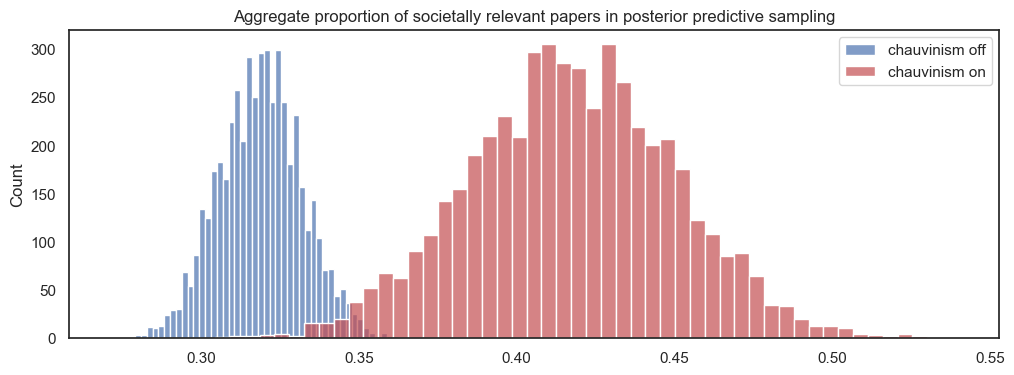

In [92]:
# we do N number of trials, each time with different reviewers, and record what proportion of 1s we get.
fig, ax = plt.subplots(figsize = (12,4))
sns.histplot(nochauv_props, bins = 50,color = 'b',alpha = 0.7,ax=ax),
sns.histplot(chauv_props, bins = 50,color = 'r',alpha = 0.7,ax=ax)

ax.legend(['chauvinism off','chauvinism on'],facecolor='white')

ax.set_title('Aggregate proportion of societally relevant papers in posterior predictive sampling')

plt.show()

# ADDITIONAL QUESTION 5: Differences between content codes

In [ ]:
content_params2 += ['No code']

# Ignore the specific UserWarnings related to tight_layout
warnings.filterwarnings('ignore', category=UserWarning)
# Convert dictionary to a long-form DataFrame for seaborn
dfx = pd.DataFrame([np.array(content_trials[i]).mean(axis = (1,2,3)) for i in content_params2 ], index = content_params2 ).T.stack().reset_index()
dfx.columns = ['index','Code','value']

# Create the ridge plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data for the ridge plot
g = sns.FacetGrid(dfx, row="Code", hue="Code", aspect=12, height=1.5, palette="tab10")

# Map the density plots to each facet
g.map(sns.kdeplot, "value", clip_on=False, shade=True, alpha=1, lw=1.5, bw_adjust=0.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Define a function to add a line for each level
def add_line(x, **kwargs):
    plt.axhline(y=x.name, color='black', lw=2, clip_on=False)

# Apply the function to each facet
g.map(add_line, "value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_xlabels("Proportion of 1s", fontsize = 25)
g.set_ylabels('')
ytick_positions = [0, 1, 2,3,4,5,6,7,8]
for ax, field in zip(g.axes.flat,content_params2 ):
    ax.set_yticks([7])  # Each subplot has a single y-tick at position 0
    ax.set_ylabel(field, fontsize = 25, rotation = 0)
    ax.tick_params(axis='x', labelsize=20)

g.despine(bottom=True, left=True)
plt.suptitle("Proportions of 1s in posterior predictive sampling from different content codes", fontsize = 25)

# Show the plot
plt.show()

In [ ]:
# plot the individual comparisons between fields
fig, axs = plt.subplots(6,6,figsize = (15,15), sharey=True)
content_effect_sizes = {}



for ax,i in zip(axs.flat, combinations(range(len(content_params2)),2)):
    
    # get the proportions of 1s in each of the ppc samples for each pair of fields
    code_a = np.array(content_trials[content_params2[i[0]]]).mean(axis = (1,2,3))
    code_b = np.array(content_trials[content_params2[i[1]]]).mean(axis = (1,2,3))
    
    # subtract the smaller from the larger
    
    
    dif = code_a - code_b

        
    # store and plot
    
    content_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax, fill=True, alpha=0.5)

    ax.set_title(f'{content_params2[i[0]]} - {content_params2[i[1]]}', fontsize=10)
    ax.axvline(0, color='r', linestyle='--')  # Use a dashed line for visual clarity
    ax.set_xlabel('Difference', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)

plt.suptitle('Difference in Proportion of 1s for Each Code Pair', fontsize=14)
fig.tight_layout()
plt.show()

# Additional question 6: Comparison roles field/content and other paper specific features

We hypothesize that the field and content codes strongly determine the paper_value. Whatever isn't captured by those, is captured by individual paper_intercepts. Here we look at how much of the variation is captured by each of these.

In [8]:
# load the trace with the hyperprior for paper_intercepts

trace_chauvinism_thurstonian_all_varpaper = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all_varpaper.nc")

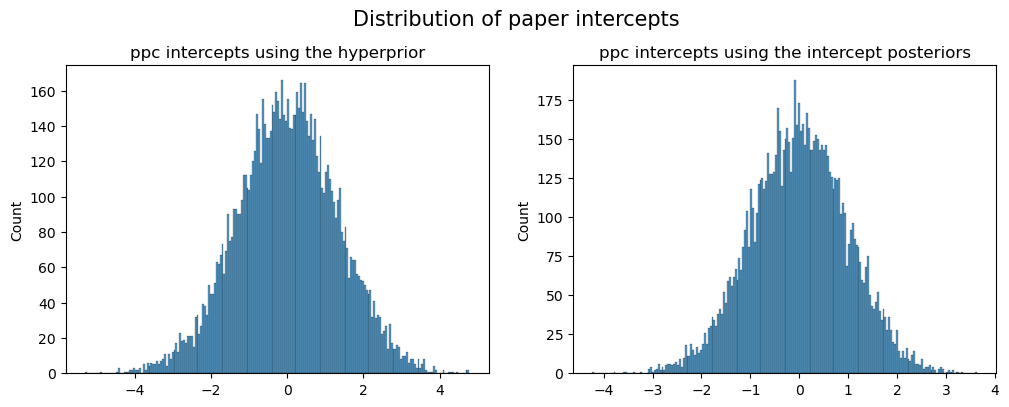

In [27]:
# expected distribution of paper_intercepts
# note, this is variation between papers not counting the role of the content codes or the field


# using the hyperprior
sds = np.random.choice(np.ravel(trace_chauvinism_thurstonian_all_varpaper.posterior['paper_var'].values), 10000, replace = True)
ppc_paper_intercepts = np.random.normal(0,sds)
plt.show()

# using the paper_intercepts themselves
# I use the content model to make comparison with field easier. The graph looks the same for the chauvinism and field models.
intercepts = np.ravel(trace_content_thurstonian_all.posterior['paper_intercepts'].values)
ppc_paper_intercepts2 = np.random.choice(intercepts, 10000, replace = True)

fig, ax = plt.subplots(ncols = 2, figsize = (12,4))

sns.histplot(ppc_paper_intercepts, bins = 200, ax=ax[0])
ax[0].set_title('ppc intercepts using the hyperprior')
sns.histplot(ppc_paper_intercepts2, bins = 200, ax=ax[1])
ax[1].set_title('ppc intercepts using the intercept posteriors')

plt.suptitle('Distribution of paper intercepts', fontsize = 15, y = 1.02)

plt.show()

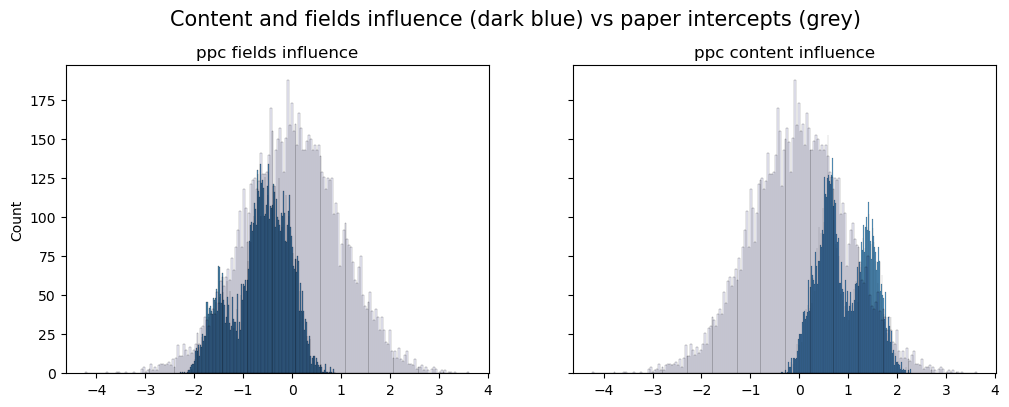

In [37]:
# now field and content

fields = np.ravel(trace_field_thurstonian_all.posterior['fields'].values)
ppc_fields = np.random.choice(fields, 10000, replace = True)

contents = np.ravel(trace_content_thurstonian_all.posterior['content'].values)
ppc_content = np.random.choice(contents, 10000, replace = True)

fig, ax = plt.subplots(ncols = 2, figsize = (12,4), sharex = True, sharey = True)

sns.histplot(ppc_fields, bins = 200, ax=ax[0])
ax[0].set_title('ppc fields influence')
sns.histplot(ppc_content, bins = 200, ax=ax[1])
ax[1].set_title('ppc content influence')

for i in range(2):
    sns.histplot(ppc_paper_intercepts2, bins = 200, color = 'blue', alpha = 0.05, ax = ax[i])

plt.suptitle('Content and fields influence (dark blue) vs paper intercepts (grey)', fontsize = 15, y = 1.02)

plt.show()